In [16]:

import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque
import heapq
random.seed(42)

# DO NOT ADD OTHER VARIABLES HERE

# General settings
seed = 42
image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 40
unsafe_iterations = 3

# Task 3 - BFS
bfs_n = 9
bfs_start_node = 2
bfs_end_node = 68

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 500
prm_connection_radius = 100
prm_start_location = (80,250)
prm_goal_location = (650, 350)

# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE


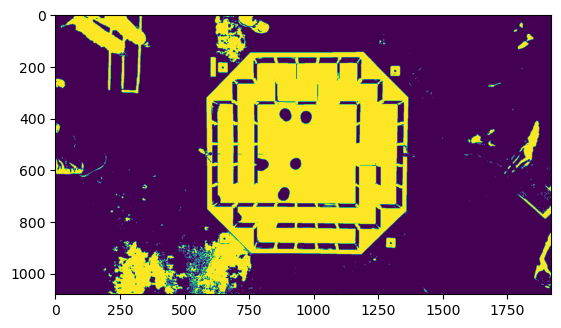

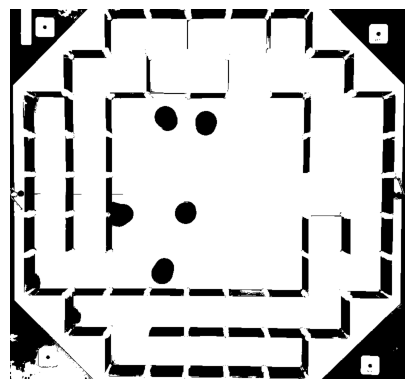

True

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("image.png")
original = img.copy()

# Convert BGR to HSV for easier color filtering
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define blue hue range (tweak if needed)
lower_blue = np.array([90, 50, 50])   # Lower bound for blue
upper_blue = np.array([130, 255, 255])  # Upper bound for blue

# Create mask of blue areas
blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Invert mask so blue areas become black (0) and rest stays
img_no_blue = img.copy()
img_no_blue[blue_mask > 0] = [255, 255, 255]  # Set blue pixels to black

# Convert to grayscale after removing blue
gray = cv2.cvtColor(img_no_blue, cv2.COLOR_BGR2GRAY)

# Apply binary threshold
_, bw_maze = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

# Crop region
# Show result
plt.imshow(bw_maze)
plt.show()
bw_maze = bw_maze[170:910, 580:1370] 

#crop the stupid line
cv2.line(bw_maze, (0, 840), (2000, 845), (255, 255, 255), 20)




plt.imshow(bw_maze, cmap='gray')
plt.axis('off')
plt.show()

# Save
cv2.imwrite("maze_bw.png", bw_maze)


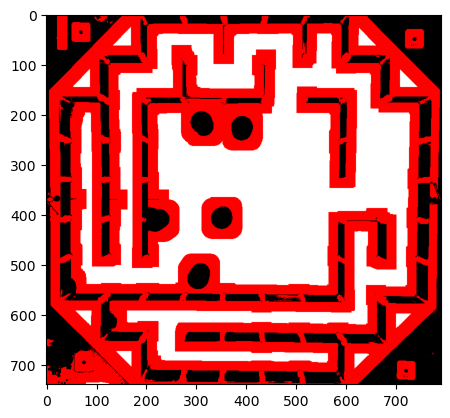

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Morphological kernel for erosion
morph_kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) 

# Keep a copy before erosion
before = bw_maze.copy()

# Apply erosion
image = cv2.erode(bw_maze, morph_kernel)

# Compute difference (absolute per pixel)
diff = cv2.absdiff(before, image)  # <-- compare before vs eroded

# --- Detect white pixels safely ---
if diff.ndim == 3 and diff.shape[2] == 3:
    white_mask = np.all(diff == [255, 255, 255], axis=2)
else:
    white_mask = diff == 255

# Ensure image is 3-channel for coloring
if image.ndim == 2 or image.shape[2] == 1:  # grayscale
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
else:
    color_image = image.copy()

# Apply red border
color_image[white_mask] = [0, 0, 255]  # BGR red

# Display
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.axis("on")
plt.show()


In [19]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id1 not in self.edges:
                self.edges[node_id1] = {}
            self.edges[node_id1][node_id2] = weight

            if node_id2 not in self.edges:
                self.edges[node_id2] = {}
            self.edges[node_id2][node_id1] = weight


    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
            
        if node_id2 in self.edges and node_id1 in self.edges[node_id2]:
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.values())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None


In [20]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):
    num_points = int(((x2 - x1)**2 + (y2 - y1)**2)**0.5) # number of points to sample along the line (smaller sample for smaller lines)
    
    # Equally spaced x and y values, then cast it to integer
    x_vals = np.linspace(x1, x2, num_points).astype(np.int32)
    y_vals = np.linspace(y1, y2, num_points).astype(np.int32)
    
    # Check if it is not white and return false for clear path
    for x, y in zip(x_vals, y_vals):
        if image[y, x] != 255:  # In grayscale, 255 means white
            return False
    return True




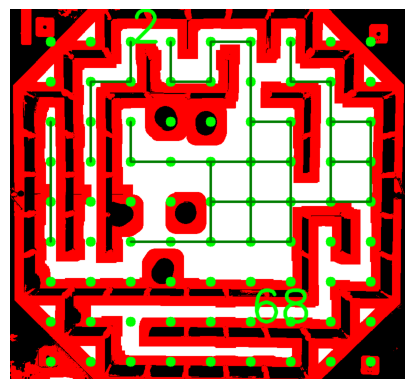

In [21]:
# Make a color copy of your maze in BGR for drawing
bfs_image = color_image.copy()  # already BGR from earlier code
bfs_graph = Graph()
img_height, img_width = bfs_image.shape[:2]
spacing = (min(img_width, img_height) + 60) / (bfs_n + 1)

# Convert maze to grayscale for path_clear function
bwimage = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

current_node_id = 0

# Create nodes in a grid layout
for row_idx in range(bfs_n):
    for col_idx in range(bfs_n):
        node_x = int(spacing + col_idx * spacing + 1)
        node_y = int(spacing + row_idx * spacing - 15)

        bfs_graph.add_node(current_node_id, node_x, node_y)

        # Draw node circle (pure green in BGR)
        cv2.circle(bfs_image, (node_x, node_y), 10, (0, 255, 0), -1)

        # Label first and last node
        if current_node_id in (bfs_start_node, bfs_end_node):
            cv2.putText(bfs_image, str(current_node_id), (node_x, node_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 5, cv2.LINE_AA)

        current_node_id += 1

# Connect nodes with edges if path between them is clear
for node_id_1 in bfs_graph.nodes:
    node_1 = bfs_graph.nodes[node_id_1]
    for node_id_2 in bfs_graph.nodes:
        if node_id_1 < node_id_2:
            node_2 = bfs_graph.nodes[node_id_2]

            diff_x = abs(node_1.x - node_2.x)
            diff_y = abs(node_1.y - node_2.y)

            # Horizontal adjacency
            if abs(diff_x - spacing) < 2 and diff_y == 0:
                if path_clear(bwimage, node_1.x, node_1.y, node_2.x, node_2.y):
                    bfs_graph.add_edge(node_id_1, node_id_2, 1)
                    cv2.line(bfs_image, (node_1.x, node_1.y), (node_2.x, node_2.y), (0, 125, 0), 3)

            # Vertical adjacency
            elif abs(diff_y - spacing) < 2 and diff_x == 0:
                if path_clear(bwimage, node_1.x, node_1.y, node_2.x, node_2.y):
                    bfs_graph.add_edge(node_id_1, node_id_2, 1)
                    cv2.line(bfs_image, (node_1.x, node_1.y), (node_2.x, node_2.y), (0, 125, 0), 3)

# Display in correct colors
plt.imshow(cv2.cvtColor(bfs_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [22]:
from collections import deque

def bfs(graph, source, target):
    # Keep track of visited nodes
    seen = set([source])

    # Queue stores tuples of (node, path_so_far)
    queue = deque([(source, [source])])

    while queue:
        node, path = queue.popleft()

        # If we reached the target, return the path
        if node == target:
            return path

        # Check neighbors
        for adj_node in graph.edges[node]:
            if adj_node not in seen:
                seen.add(adj_node)
                queue.append((adj_node, path + [adj_node]))

    # No path found
    return []


Path: []


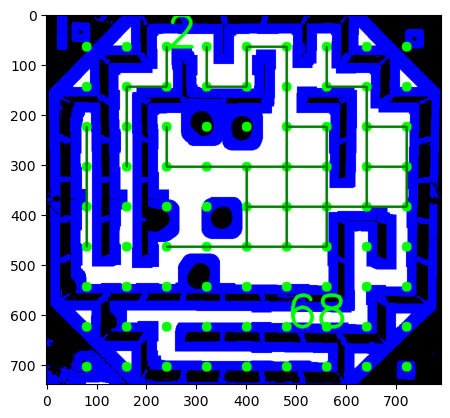

In [23]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

# Go through each pair of nodes along the path
for node in range(len(path) - 1):
    # Get the current node's coordinates
    node_1 = bfs_graph.nodes[path[node]]
    # Get the next node's coordinates
    node_2 = bfs_graph.nodes[path[node + 1]]
    x1, y1 = node_1.get_point()
    x2, y2 = node_2.get_point()
    
    # Connect the line
    cv2.line(bfs_image, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 6)

# Display the resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

In [24]:
def node_to_coord(node_id, width=9):
    return (node_id // width, node_id % width)

def get_direction(from_node, to_node):
    r1, c1 = node_to_coord(from_node)
    r2, c2 = node_to_coord(to_node)
    return (r2 - r1, c2 - c1)

def direction_to_str(d):
    # For debugging only
    mapping = {
        (-1,0): "Up",
        (1,0): "Down",
        (0,-1): "Left",
        (0,1): "Right"
    }
    return mapping.get(d, str(d))

def turn_instructions(current_facing, desired_facing):
    # Directions: Up, Right, Down, Left mapped to vectors
    directions = [(-1,0), (0,1), (1,0), (0,-1)]
    current_idx = directions.index(current_facing)
    desired_idx = directions.index(desired_facing)

    diff = (desired_idx - current_idx) % 4

    if diff == 0:
        return []  # no turn
    elif diff == 1:
        return ["r"]
    elif diff == 2:
        return ["r", "r"]
    elif diff == 3:
        return ["l"]
    else:
        return []

def path_to_instructions(path):
    instructions = []
    current_facing = (-1, 0)  # Start facing Up

    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i+1]

        desired_direction = get_direction(from_node, to_node)
        # Determine turns needed
        turns = turn_instructions(current_facing, desired_direction)
        instructions.extend(turns)
        instructions.append("f")

        current_facing = desired_direction  # update facing

    return instructions

# Example usage:

instrs = path_to_instructions(path)
print(instrs)


[]


In [25]:
# This is a useful function that you may choose to implement and use 
# It finds and returns the closest nodes that are within the range
def find_closest_nodes(image,graph, target_x, target_y, range):
    
    distances = []
    
    # Check all the nodes
    for node in graph.get_nodes():
        x, y = node.get_point()
        # Calculate distance between two points
        dist =  int(((target_x - x)**2 + (target_y - y)**2)**0.5)
        
        if 0 < dist <= range:
            # Check if path is clear
            if path_clear(image, x, y, target_x, target_y):
                # Add this node's ID and distance to the list
                distances. append ((node.get_ID(), dist))
                
    # Sort by distance - short distance first
    distances.sort(key=lambda x: x[1])  
    return distances

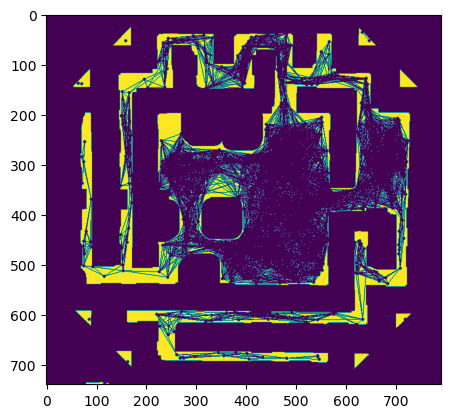

In [26]:
# Task 4.1 (3 marks): PRM
# NOTE: The iteration only increases when a valid node is placed on the map. If the node is invalid, the program should continue without incrementing the node count. 

prm_image = image.copy()
prm_graph = Graph()
random.seed(seed)

i = 0 # valid node added counter

# Add node until we reach the maximum amount defined
while i < prm_total_nodes_count:
    # Generate a random (x, y) coordinate within the image bounds (x and y were swapped from stub, as per edstem post #125
    y = random.randint(0, prm_image.shape[0]-1)
    x = random.randint(0, prm_image.shape[1]-1)
    
    # check if area s white
    if bwimage[y, x] > 127:
        # Add the node to the graph with a unique ID and position
        prm_graph.add_node(i, x, y)
        # Draw a green dot
        cv2.circle(prm_image, (x, y), 3, (0, 255, 0), -1)
        
        # use bwimage because it calls path_clear, which is written for gray image
        closest_nodes = find_closest_nodes(bwimage, prm_graph, x, y, prm_connection_radius)
        
        # Find nearby nodes within the connection radius
        for node_id, dist in closest_nodes: 
            prm_graph.add_edge(i, node_id, dist)
            
            # Get its point then draw line connecting the nodes
            node_pt = prm_graph.nodes[node_id].get_point()
            cv2.line(prm_image, (x,y), node_pt, (0,125,0),1)
        i += 1

# Display the resulting image
plt.imshow(prm_image)
plt.show()

In [27]:
# Task 4.2 (3 marks): Djistraks
# Example output - Path: [-1, 143, 43, 1, 14, 44, 67, 7, 9, 4, 12, 364, -2], Cost: 561.9189671797234
def dijkstra(graph, start_id, end_id):

    path = []
    total_cost = 0
    queue = [(0, start_id, [start_id])]
    visited = set() 

    while queue:
        # Get the node with the smallest cost so far
        cost, current_node, path = heapq.heappop(queue)
        
        # Skip nodes already processed
        if current_node in visited:
            continue
        visited.add(current_node)
        
        # If target reached, return the path and cost
        if current_node == end_id:
            return (path, cost)
        
        # Check all neighboring nodes
        for neighbor_id, weight in graph.edges[current_node].items():
            if neighbor_id not in visited:
                # Push new path and accumulated cost to the queue
                heapq.heappush(queue, (cost + weight, neighbor_id, path + [neighbor_id]))

    return (path, total_cost)

Path: [-1, 456, 322, 392, 169, 24, 338, 280, 466, 492, 62, 137, 305, 369, 50, 109, 268, 243, -2], Cost: 859.5653383324689


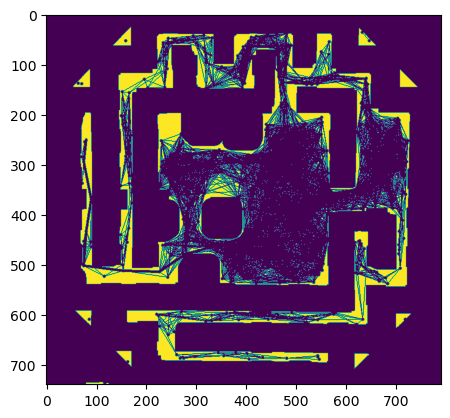

In [28]:
# Task 4.2: Djistraks continued

# Add start (node id = -1) and end (node_id = -2 ) nodes 
prm_graph.add_node(-1, prm_start_location[0], prm_start_location[1])  # start node
prm_graph.add_node(-2, prm_goal_location[0], prm_goal_location[1])    # end node

# Connect start and goal nodes to nearby nodes in the PRM
for node_id, node in prm_graph.nodes.items():
    if node_id in [-1, -2]:
        continue  # skip connecting the node to itself
    # Try connecting this node to both start and end nodes
    for special_id, special_loc in [(-1, prm_start_location), (-2, prm_goal_location)]:
        # Calculate Distance
        dist = math.hypot(node.x - special_loc[0], node.y - special_loc[1])
        
        # Check if the distance is withing the radius
        if dist <= prm_connection_radius:
            # Ensure path between them is obstacle-free and connect
            if path_clear(bwimage, node.x, node.y, special_loc[0], special_loc[1]):
                prm_graph.add_edge(special_id, node_id, dist)
                prm_graph.add_edge(node_id, special_id, dist)
                cv2.line(prm_image, (node.x, node.y), special_loc, (0,125,0),1)

# Run Dijkstra’s algorith
path, cost = dijkstra(prm_graph, -1, -2)

# Draw the path
for i in range(len(path)-1):
    pt1 = prm_graph.nodes[path[i]].get_point()
    pt2 = prm_graph.nodes[path[i+1]].get_point()
    cv2.line(prm_image, pt1, pt2, (0, 0, 255), 3)


# Display the resulting image
print(f"Path: {path}, Cost: {cost}")
plt.imshow(prm_image)
plt.show()


In [33]:
import math

def get_move_instructions(graph, path):
    instructions = []
    for i in range(len(path) - 1):
        # Get coordinates of current and next node
        x1, y1 = graph.nodes[path[i]].x, graph.nodes[path[i]].y
        x2, y2 = graph.nodes[path[i+1]].x, graph.nodes[path[i+1]].y
        
        scaling = 4
        x1 = x1 / scaling
        x2 = x2 / scaling
        y1 = y1 / scaling
        y2 = y2 / scaling
        
        # Distance
        distance = math.hypot(x2 - x1, y2 - y1)
        
        # Heading: 0° = up, increases clockwise, inverted compass
        dx = x2 - x1
        dy = y2 - y1
        heading = (math.degrees(math.atan2(dx, -dy)) + 90 + 180) % 360
        
        # Add tuple-like string: (heading, distance)
        instructions.append(f"({heading:.0f}, {distance:.0f})")
    
    # Join into a single string separated by "; "
    return "; ".join(instructions)

# Example usage:
output = get_move_instructions(prm_graph, path)
print(output)


(96, 11); (79, 19); (99, 16); (94, 17); (6, 5); (7, 15); (2, 18); (326, 14); (323, 2); (346, 11); (345, 3); (356, 4); (339, 2); (336, 17); (335, 24); (342, 13); (344, 8); (345, 16)


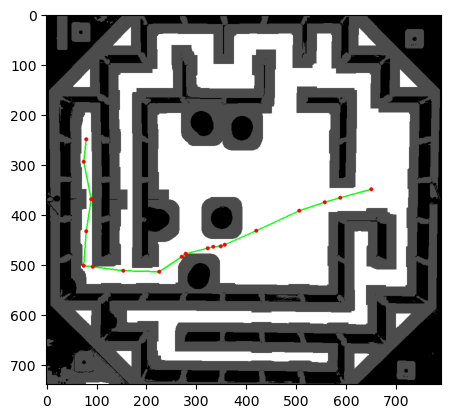

In [30]:
import cv2
import numpy as np

def draw_path_on_maze(graph, path, maze_image, node_color=(0,0,255), edge_color=(0,255,0)):
    """
    Draws only the path nodes & edges on top of the maze image.
    
    maze_image: your original map (BGR or grayscale)
    """
    # Make sure maze is BGR so we can draw colors
    if len(maze_image.shape) == 2:
        maze_bgr = cv2.cvtColor(maze_image, cv2.COLOR_GRAY2BGR)
    else:
        maze_bgr = maze_image.copy()
    
    # Draw edges in path
    for i in range(len(path) - 1):
        pt1 = graph.nodes[path[i]].get_point()
        pt2 = graph.nodes[path[i+1]].get_point()
        cv2.line(maze_bgr, pt1, pt2, edge_color, 2)

    # Draw nodes in path
    for node_id in path:
        x, y = graph.nodes[node_id].x, graph.nodes[node_id].y
        cv2.circle(maze_bgr, (x, y), 4, node_color, -1)

    return maze_bgr

# Example usage:
final_path_image = draw_path_on_maze(prm_graph, path, bwimage)  # bwimage = your maze map
plt.imshow(cv2.cvtColor(final_path_image, cv2.COLOR_BGR2RGB))
plt.show()
